<a href="https://colab.research.google.com/github/Dharani1999/Word-embedding-techniques/blob/master/Code_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import gensim
from gensim import corpora, models, similarities
from gensim.models import Word2Vec, TfidfModel, LsiModel
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [29]:
max_seq_length = 100

In [30]:
ratings1 = pd.read_csv('/content/drive/My Drive/Movielensdata/ml25m/ratings.csv')
ratings = ratings1.iloc[0:1000,:]
#print(len(ratings['movieId'].unique()))
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [31]:
def embedding_model(name,Dataset,max_seq_len,vector_dims=50,Sg=1,size_window=3,topics=10,mini_count=1,num_workers=3,max_epochs = 100,alpha = 0.025):
  if name == 'word2vec':
    #model1 = Word2Vec.load('/content/drive/My Drive/Movielensdata/ml25m/wordtovec')
    data_corpus = []
    data_corpus, users = data_word2vec(Dataset,max_seq_len)
    model1 = Word2Vec(data_corpus,min_count=mini_count,size= vector_dims,workers=num_workers, window =size_window, sg = Sg)
    voc = model1.wv
    words = list(model1.wv.vocab)
    vectors = model1[model1.wv.vocab]
  elif name == 'doc2vec':
    model1 = Doc2Vec.load('/content/drive/My Drive/Movielensdata/ml25m/d2v.model')
    data_corpus = data_doc2vec(Dataset,max_seq_len)
  elif name == 'lsi':
    model1 = LsiModel.load('/content/drive/My Drive/Movielensdata/ml25m/lsimodel')
    data_corpus = data_lsi(Dataset,max_seq_len)
  elif name == 'tfidf':
    model1 = TfidfModel.load('/content/drive/My Drive/Movielensdata/ml25m/tfidf_model')
    data_corpus = data_lsi(Dataset,max_seq_len)
  return voc, vectors, words

In [32]:
def data_word2vec(dataset,max_seq_length):
  dataset.sort_values(by=['userId','timestamp'],inplace=True)
  users_total = len(dataset['userId'].unique())
  
  #Selecting the most recent movies rated by each user and padding if necessary
  movie_list = []
  for i in range(users_total):
    list1 = []
    list1 = dataset.loc[dataset['userId'] ==(i+1),['movieId']]['movieId'].tolist()
    if len(list1)>max_seq_length:
      list1 = list1[(len(list1)-max_seq_length):]
    elif len(list1)<max_seq_length:
      for j in range((max_seq_length-len(list1))):
        list1.append(0)
    movie_list.append(list1)
  
  #Selecting the most recent ratings rated by each user and padding if necessary
  rating_list =[]
  for i in range(users_total):
    list2 = []
    list2 = dataset.loc[dataset['userId'] ==(i+1),['rating']]['rating'].tolist()
    if len(list2)>max_seq_length:
      list2 = list2[(len(list2)-max_seq_length):]
    elif len(list2)<max_seq_length:
      for j in range((max_seq_length-len(list2))):
        list2.append(0)
    rating_list.append(list2)
  
  #Creating user_id level transpose matrices
  movies_transpose = pd.DataFrame(data=movie_list,index=[i+1 for i in range(users_total)])
  movies_transpose.index.names = ['userId']
  #print(movies_transpose)

  ratings_transpose = pd.DataFrame(data=rating_list,index=[i+1 for i in range(users_total)])
  ratings_transpose.index.names = ['userId']
  #print(ratings_transpose)

  # Select features from original dataset to form a new dataframe 
  df1 = movies_transpose.iloc[:]# For each row, combine all the columns into one column
  df2 = df1.apply(lambda x: ','.join(x.astype(str)), axis=1)# Store them in a pandas dataframe
  df_clean = pd.DataFrame({'clean': df2})# Create the list of list format of the custom corpus for gensim modeling 
  sent = [row.split(',') for row in df_clean['clean']]

  return sent, users_total

In [33]:
def data_doc2vec(dataset,max_seq_length):
  Sent, user_total = data_word2vec(dataset,max_seq_length)
  tagged_data = []
  tags = []
  #test_data = []
  #test_data = test_data + Sent[3]
  for i in range(user_total):
    tagged_data = tagged_data + [TaggedDocument(words=Sent[i], tags=[str(i)])]
  #print(tagged_data)
  #print(test_data)
  return tagged_data

In [34]:
def data_lsi(dataset,max_seq_length):
  Sent, user_total = data_word2vec(dataset,max_seq_length)
  corpus = gensim.matutils.Dense2Corpus(np.array(Sent),documents_columns=False)
  #print(list(corpus))
  return corpus

In [35]:
#def data_tfidf(dataset,max_seq_length):
 # Sent, user_total = data_word2vec(dataset,max_seq_length)
  #corpus = gensim.matutils.Dense2Corpus(np.array(Sent),documents_columns=False)
  #return corpus

In [36]:
vocab, word_vectors, words  = embedding_model(name='word2vec',Dataset=ratings,max_seq_len=max_seq_length,vector_dims=50,topics=10,mini_count=1,num_workers=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [37]:
print(vocab['5952'])

[ 1.3106577e-03 -8.3523300e-03 -4.3170047e-03  3.1313777e-03
  1.0932399e-03  7.4501489e-03  9.5436163e-03  5.1000486e-03
 -4.1634734e-03  4.7428873e-03  7.6846015e-03 -9.7214421e-03
 -6.0394406e-03 -4.7888486e-03 -5.9087072e-03  9.3882969e-03
 -1.9535533e-05  2.1959180e-03 -5.9817252e-03  7.7871834e-03
  7.6294346e-03  1.4977332e-03  2.6828388e-03  5.1264288e-03
  5.9411075e-04 -1.6188512e-03 -1.5732608e-03  5.3431839e-03
  2.7579023e-03  5.9659022e-04 -5.6259274e-03 -8.9347679e-03
  4.6979878e-03  4.7632335e-03  8.2617940e-04  9.7235525e-03
 -5.7273721e-03 -5.9812092e-03 -5.6288582e-03  7.0965397e-03
 -1.9811583e-03 -9.9067455e-03 -4.8440876e-03 -5.9495717e-03
 -4.9326937e-03  6.0471706e-03 -8.3456933e-03  3.4863185e-03
 -5.0836955e-03 -9.8088989e-03]


In [38]:
print(words)

['5952', '2012', '2011', '1653', '1250', '6539', '6377', '3448', '1088', '899', '4308', '2161', '6711', '3949', '8360', '5878', '306', '1175', '307', '1237', '7327', '8154', '7234', '2843', '4144', '7365', '2068', '4422', '4973', '6016', '8873', '2692', '27721', '7323', '6954', '8014', '7939', '6370', '8973', '4703', '31956', '5147', '8786', '1260', '2351', '7940', '7209', '8685', '7820', '7937', '7938', '8405', '4325', '2632', '1217', '8729', '5912', '5767', '665', '2573', '27266', '8327', '32591', '5269', '3569', '27193', '5684', '7318', '296', '7361', '0', '4306', '8368', '3793', '4995', '4963', '8636', '2355', '8665', '2571', '589', '33493', '7153', '1873', '1246', '1584', '3994', '2139', '31923', '4720', '2294', '2745', '2138', '858', '33660', '2268', '2501', '1270', '6565', '4535', '1198', '1302', '349', '3098', '1907', '1580', '364', '480', '3360', '524', '5103', '62', '7075', '1287', '260', '318', '588', '1693', '1196', '4993', '2918', '3105', '5955', '1275', '1393', '6879', '5

In [39]:
print(word_vectors)

[[ 0.00131066 -0.00835233 -0.004317   ...  0.00348632 -0.0050837
  -0.0098089 ]
 [-0.00612565  0.00510299  0.00152161 ...  0.00281257 -0.00838187
   0.00340109]
 [-0.0031283   0.00095094 -0.0040891  ...  0.00246996  0.00141303
  -0.00702919]
 ...
 [-0.00177746 -0.00400526 -0.00425009 ... -0.00054444 -0.00595155
  -0.00721892]
 [ 0.00576747 -0.00575028  0.00087766 ...  0.0031354   0.00232449
   0.00263823]
 [ 0.0056342  -0.0038641  -0.00267407 ... -0.00780115  0.00802095
  -0.00150831]]


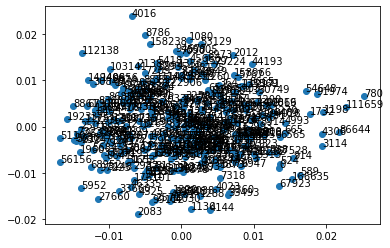

In [40]:
from sklearn.decomposition import PCA
X = word_vectors
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()